### Метод Ньютона

Задание

1. ответить на все вопросы в скрипте
2. изменить код метода Ньютона так, чтобы он смог разрешать все проблемные случаи, возникающие в скрипте, продемонстрировать это, объяснить почему модификация решает проблему. Проблемы - нулевая производная, кратные корни, биения. Для кратных корней надо так модифицировать метод, чтобы порядок оставался вторым и продемонстрировать это.

ВАЖНО! Модифицированный метод Ньютона должен получаться путем добавления новых строчек в simple_newton, а не переписыванием его с нуля. Новые строчки надо прокомментировать, зачем они были добавлены.

In [48]:
# простая реализация Метода Ньютона
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np

def simple_newton(func, dfunc, x, tol = 1e-12):
    sol = 0
    iteration = 0
    dxs = []
    for i in range(30):
        iteration += 1
        dx = -func(x)/dfunc(x)
        dxs.append(abs(dx))
        x = x + dx
        if abs(dx) < tol:
            sol = x
            return [sol, iteration, dxs]
    sol = float('nan')
    print('More then 30 iterations!')
    return [sol, iteration]

In [49]:
# модифицированный

#в первую очередь проблемы с областью сходимости, потому что метод Ньютона не гарантирует глобальную сходимость
#как я понимаю, работать должно для любых функций, но я не знаю как это сделать (это вообще разве реально,  если у нас нет глобальной сходимости?)
#я решила искать доверительные интервалы, а точнее, найти интервал, что f(x_n)f(b)<0 и там брать новое значение x_n
#от кратных корней нам будут помогать два параметра q_n = (x_{n+1}-x_n)/(x_n-x_{n-1}) и p_n = 1/(1-q_n), которые на каждой итерации n вычисляют кратность корня p (p_n --> p)
def check(func, dfunc, x): #эта функция ищет другое начальное значение, если в нашем случайно произошло обнуление. Ищет неоптимально, потому что только проверяет значение на концах, но я смогла учесть все изменения производных, поэтому пришлось ограничить так сильно
    k=0
    while k <=10:
        if func(x) * func(x+k) < 0:
            return (x+x+k)/2
        k = +1
    k=0
    while k <=10:
        if func(x) * func(x-k) < 0:
            return (x+x-k)/2
        k = +1
    return x
    #если функция не смогла найти другую точку, то мы заканчиваем работу с выводом плохое приближение

def modify_newton(func, dfunc, x, tol = 1e-12):
    sol = 0
    iteration = 0
    dxs = []
    q_0 = 0
    q_1 = 0
    p = 0
    for i in range(30):
        iteration += 1
        if dfunc(x) == 0:
            if check(func, dfunc, x) == x:
                sol = float('nan')
                print('bad initial guess')
                return [sol, iteration]
            else:
                x = check(func, dfunc, x)
        dx = -func(x)/dfunc(x)
        dxs.append(abs(dx))
        if iteration == 1: #потому что нижняя разность для вычисления q еще не определена
            p = 1
        else:
            q_0 = q_1
            q_1 = dxs[i-1]/dxs[i-2]
            if abs(q_1-q_0) < 1e-12:
                p = 1/(1-q_1)
            else: p = 1
        x = x + p * dx  #соображения те же, что и в методе Ньютона. Я не проверяю при этом сходимость q и p, а по-хорошему нужно. Пришлось изменить эту вашу строчку,, одну всего
        if abs(dx) < tol:
            sol = x
            return [sol, iteration, dxs]
    sol = float('nan')
    print('More then 30 iterations!')
    return [sol, iteration]

#### Нелинейное уравнение 1

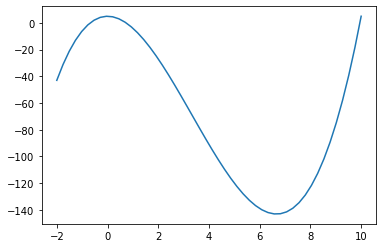

In [50]:
x = np.linspace(-2,10)
func0 = lambda x: x**3 - 10*x**2 + 5
dfunc0 = lambda x: 3*x**2 - 20*x
y = func0(x)
plt.plot(x, y)

1. Объяснить, почему различаются результаты в случае 1 и 2 

    Результаты различаются потому что нахождение корней определяется локальной сходимостью, т.е. напрямую зависят от начального приближения, поэтому в первому случае он находит корень, ближайший к 8, а во втором - к 0.7
    
2. Объяснить, что происходит в случае 3

    В третьем случае мы начинаем со стационарной точки, в которой производная равна нулю. Поэтому исходный код simple_newton не работает - внутри кода мы делим на производную. В моем модифицированном коде мы идем сначала вправо и находим ближайщий отрезок где $f(x) * f(b)<0$. Если находим за десять проходов (при этом каждый раз $b = x+k, 0< k\leq 10$), то берем середину отрезка $(b+x)/2$ в качестве $x$ и продолжаем алгоритм, если не находм справа, то ищем слева, если нигде не находим, то говорим, что приближение плохое. Для улучшения, возможно нужно меньше взять шаг $k$ и увеличить число итераций


In [51]:
data = modify_newton(func0, dfunc0, 8) # случай 1
#data = modify_newton(func0, dfunc0, 0.7) # случай 2
#data = modify_newton(func0, dfunc0, 0.0) # случай 3
print('sol = ', data[0])
print('iter = ', data[1])

sol =  9.949491057914388
iter =  7


3. Построить график порядка сходимости от номера итерации. Объяснить результат
    
    За сходимость отвечает $dxs[]$, т.к. в ней лежат $dx$ на каждой итерации. Оценим нашу погрешность на $n+1$ итерации (расписывала на листочке у себя)
    $$ |x_{n+1}-x^*| \leq \alpha |x_n - x^*|^2 \leq \cdot \leq \alpha^{2^{n+1}-1}|x_0-x^*|^{2^n} $$
    т.е. теперь наша погрешность зависит и от $\alpha$ и от $|x_0-x^*|$ как степенная в степенной, т.е. если произведение $\alpha |x_0-x^*| < 1$, то наше решение будет сходиться. При этом будет очень быстро убывать. На рисунке будет график для первого случая (при желании можно заменить, если заменить вызываемый случай) и еще приведу график $y = 0.7^{2^x}$, 0.7 беру просто для примера, т.к. 0.7 < 1 (0.7 в данном случае символизирует $\alpha|x_0-x^*|$. Видим, что у графиков только минимальные различия вначале, где еще влияет то, что в настоящей оценке у $\alpha$ степень двойки $n+1$, а не $n$, и еще есть степень $-1$. Можно посмотреть на другие графики, поизменять $0.7$ - самое главное, что характер убывания одинаковый

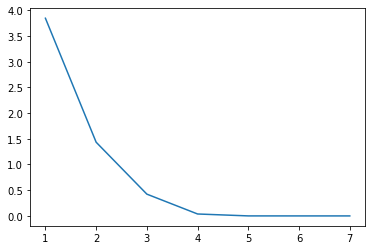

In [52]:
x = np.linspace(1,data[1], data[1])
y = data[2]
plt.plot(x, y)

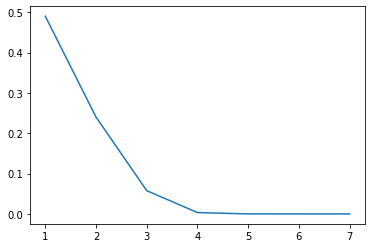

In [53]:
x = np.linspace(1,data[1], data[1])
y = 0.7 ** (2 ** x)
plt.plot(x, y)

#### Нелинейное уравнение 2

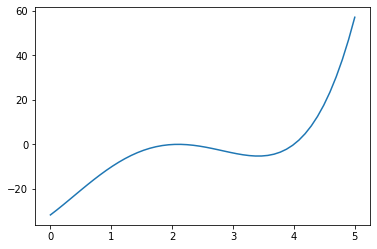

In [55]:
x = np.linspace(0,5)
func1 = lambda x: x**4 - 6.4*x**3 + 6.45*x**2 + 20.538*x - 31.752 #double root
dfunc1 = lambda x: 4.0*x**3 - 19.2*x**2 + 12.9*x + 20.538
y = func1(x)
plt.plot(x, y)

1. Построить график порядка сходимости от номера итерации. Объяснить результат

In [56]:
data = modify_newton(func1, dfunc1, 2.0)
print('sol = ', data[0])
print('iter = ', data[1])

sol =  2.0999999786199406
iter =  23


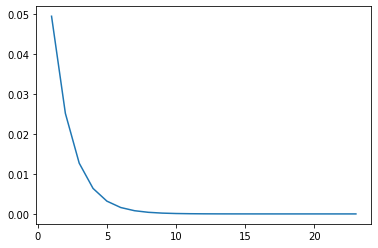

In [57]:
x = np.linspace(1,data[1], data[1])
y = data[2]
plt.plot(x, y)

#### Нелинейное уравнение 3

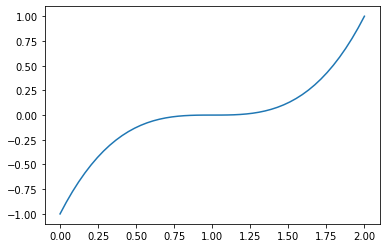

In [58]:
x = np.linspace(0,2)
func2 = lambda x: (x-1)**3
dfunc2 = lambda x: 3*(x-1)**2
y = func2(x)
plt.plot(x, y)

1. Подобрать начальное приближение и решить задачу

In [59]:
data = simple_newton(func2, dfunc2, 1)
print('sol = ', data[0])
print('iter = ', data[1])

ZeroDivisionError: division by zero

#### Нелинейное уравнение 4

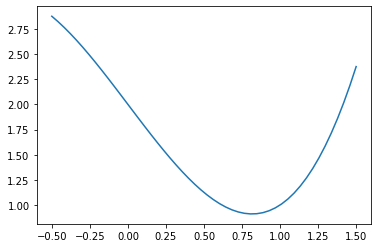

In [60]:
x = np.linspace(-0.5,1.5)
#x = np.linspace(-5,5)
func3 = lambda x: x**3 - 2*x + 2
dfunc3 = lambda x: 3*x**2 - 2
y = func3(x)
plt.plot(x, y)

1. Почему не находится решение во втором случае?

In [62]:
#data = simple_newton(func3, dfunc3, 0.5) # случай 1
data = simple_newton(func3, dfunc3, 0) # случай 2
print('sol = ', data[0])
print('iter = ', data[1])

More then 30 iterations!
sol =  nan
iter =  30
